In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import os
from sklearn.metrics import f1_score
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from datetime import datetime
from xgboost import XGBClassifier
from numpy import inf
import pickle

In [33]:
# Путь к директории с данными

data_dir = '../00_data/track_1/'
sumbit_dir = '../02_submits/'
preprocessed_dir = '../03_preprocessed_data/'

X_train = pd.read_csv(preprocessed_dir + 'X_train.csv')
X_test = pd.read_csv(preprocessed_dir + 'X_test.csv')
y_train = pd.read_csv(preprocessed_dir + 'y_train.csv')
y_test  = pd.read_csv(preprocessed_dir + 'y_test.csv')
X = pd.read_csv(preprocessed_dir + 'X.csv')
unused_features = [ 'is_test']
cat_col = [x for x in X_train.columns if 'code'  in x]
unused_features = unused_features + cat_col
use_for_train = ['year', 'station_id', 'day', 'ice_jam_same_day_last_year',
       'ice_jam_same_day_last_year_prev_stat', 'ice_jam_same_day_prelast_year',
       'is_prelast_year_missing', 'n_jams_last_year',
       'n_jams_prelast_year', 'n_jams_last_year_prev_station', 'n_jams_past',
       'n_jams_past_prev_stat', 'n_same_days_before',
       'n_ice_jams_same_days_before', 'n_ice_jams_same_days_before_ratio', 'station_width']
#
use_for_train = ['year', 'station_id', 'day', 
       'ice_jam_same_day_last_year', 
       'ice_jam_same_day_prelast_year', 
                 'is_last_year_missing',
       'is_prelast_year_missing', 
                 'n_jams_last_year',
                 'n_jams_prelast_year',
       'n_jams_past',  'n_ice_jams_same_days_before',
       'n_ice_jams_same_days_before_ratio',
       'distance_from_source', 'drainage_area', 'z_null', 
       'height_diff_by_dist']


C:\Users\omore\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (45,65,122,142,199,430,604,661,681) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\omore\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (45,65,122,142,199,276,604,661,681) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\omore\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (46,66,123,143,200,277,431,605,662,682) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


from sklearn.feature_selection import SelectKBest
N_features = 50
unused_features = unused_features + cat_col
feature_selector = SelectKBest(k = N_features)
features = X_train.drop(unused_features, axis = 1).columns
feature_selector = feature_selector.fit(X_train.drop(unused_features, axis = 1), y_train)
#X_train_new = .fit_transform(X_train.drop(unused_features, axis = 1), y_train)
#X_train_new.shape
use_for_train = features[feature_selector.get_support()]
use_for_train

In [34]:
use_for_train = use_for_train + \
    [x for x in X_train.columns if 'stage_max'  in x] + \
    [x for x in X_train.columns if 'air'  in x] + \
    [x for x in X_train.columns if 'inc'  in x] 
use_for_train = list(set(use_for_train))

In [35]:
drop_summer = [x for x in X_train.columns if '6_'  in x] + \
    [x for x in X_train.columns if '7_'  in x] + \
    [x for x in X_train.columns if '8_'  in x]+ \
    [x for x in X_train.columns if '9_'  in x]

len(drop_summer)

308

In [36]:
#use_for_train = [x for x in X_train.columns if x not in (unused_features + ['ice_jam'] + drop_summer )]
len(use_for_train)

97

In [83]:
use_for_train

['10_max_stage_max',
 '11_stage_inc_monthly',
 '2_std_air',
 '9_mean_air',
 '11_std_stage_max',
 'distance_from_source',
 '7_std_stage_max',
 'n_jams_prelast_year',
 '8_std_stage_max',
 '1_max_stage_max',
 '1_mean_stage_max',
 '8_max_air',
 '8_mean_stage_max',
 '10_mean_air',
 '12_std_air',
 'is_prelast_year_missing',
 '1_mean_air',
 '12_min_stage_max',
 'year',
 '8_stage_inc_monthly',
 '7_min_air',
 '9_std_stage_max',
 '11_max_air',
 '6_stage_inc_monthly',
 '2_max_stage_max',
 '6_std_stage_max',
 '2_min_air',
 '9_max_stage_max',
 '6_min_air',
 '10_std_air',
 '8_max_stage_max',
 'n_jams_past',
 '12_max_stage_max',
 '10_min_air',
 '12_min_air',
 'is_last_year_missing',
 '7_max_air',
 'station_id',
 '7_std_air',
 '6_mean_air',
 '2_min_stage_max',
 '12_mean_stage_max',
 '6_max_air',
 '11_min_stage_max',
 '9_min_air',
 '2_mean_stage_max',
 '7_min_stage_max',
 '1_min_air',
 'day',
 '6_std_air',
 'ice_jam_same_day_last_year',
 '2_std_stage_max',
 '1_std_air',
 '7_stage_inc_monthly',
 '11_mea

# Random Forest

In [37]:
X_train_used = X_train[use_for_train]
# X_train_used = X_train[[use_for_train]].drop(unused_features, axis = 1)
X_test_used  = X_test[use_for_train]
# X_test_used = X_test[[use_for_train]].drop(unused_features, axis = 1)

mod_RF = RandomForestClassifier(class_weight = 'balanced')
mod_RF.fit(X_train_used, y_train)        

y_pred = mod_RF.predict(X_test_used)
y_train_pred = mod_RF.predict(X_train_used)

print('F1-train: {}'.format(f1_score(y_train, y_train_pred)))
print('F1-test: {}'.format(f1_score(y_test, y_pred)))

C:\Users\omore\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


F1-train: 1.0
F1-test: 0.0


In [38]:
from sklearn.linear_model import LogisticRegression

mod_logreg = LogisticRegression(class_weight = 'balanced', max_iter= 10000)
mod_logreg.fit(X_train_used, y_train)        

y_pred = mod_logreg.predict(X_test_used)
y_train_pred = mod_logreg.predict(X_train_used)

print('F1-train: {}'.format(f1_score(y_train, y_train_pred)))
print('F1-test: {}'.format(f1_score(y_test, y_pred)))

C:\Users\omore\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


F1-train: 0.06889128094725512
F1-test: 0.03387220939183987


In [53]:
model = XGBClassifier(scale_pos_weight = 50, n_estimators = 500, random_state=0)
eval_set =[(X_test_used, y_test)]
model.fit(X_train_used, y_train, early_stopping_rounds = 2, 
                      eval_metric="error",
                     eval_set=eval_set , verbose=True)   

y_pred = model.predict(X_test_used)
y_train_pred = model.predict(X_train_used)

print('F1-train: {}'.format(f1_score(y_train, y_train_pred)))
print('F1-test: {}'.format(f1_score(y_test, y_pred)))

[0]	validation_0-error:0.16436
Will train until validation_0-error hasn't improved in 2 rounds.
[1]	validation_0-error:0.09285
[2]	validation_0-error:0.09950
[3]	validation_0-error:0.07844
[4]	validation_0-error:0.08121
[5]	validation_0-error:0.05543
[6]	validation_0-error:0.05903
[7]	validation_0-error:0.04490
[8]	validation_0-error:0.04130
[9]	validation_0-error:0.03908
[10]	validation_0-error:0.03437
[11]	validation_0-error:0.03326
[12]	validation_0-error:0.02605
[13]	validation_0-error:0.02051
[14]	validation_0-error:0.02411
[15]	validation_0-error:0.02051
Stopping. Best iteration:
[13]	validation_0-error:0.02051

F1-train: 0.3003952569169961
F1-test: 0.075


Text(0.5, 0, 'Random Forest Feature Importance')

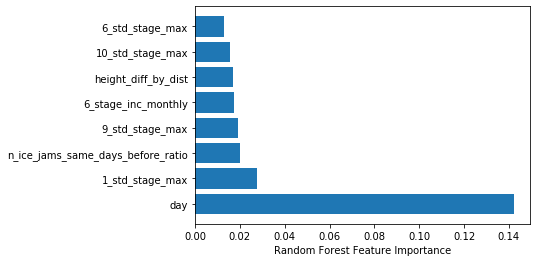

In [17]:
importances = mod_RF.feature_importances_
feature_names = X_train_used.columns
sorted_idx = importances.argsort()[::-1]


plt.barh(feature_names[sorted_idx][0:10], importances[sorted_idx][0:10])
plt.xlabel("Random Forest Feature Importance")


In [18]:
mod_RF = RandomForestClassifier() # or GradientBoostingClassifier, or XGBoostClassifier

search_grid_RF = {'bootstrap': [True],
                  'max_depth': [2, 3, 4, 5, 6],
                  'max_features': [3, 4, 5, 6],
                  'n_estimators': [5, 10, 20, 50],
                  'min_samples_leaf': [10, 25, 50],
                  'min_samples_split': [25, 50],
                  'random_state': [29],
                  'class_weight': ['balanced']
                  }

param_search_RF = GridSearchCV(estimator=mod_RF, 
                               param_grid=search_grid_RF, 
                               scoring=metrics.make_scorer(metrics.f1_score),
                               cv=3, 
                               n_jobs=-1, 
                               verbose=2, return_train_score=True,
                               iid=True)

#param_search_RF.fit(X_train[[use_for_train]].drop(unused_features, axis = 1), y_train)        
param_search_RF.fit(X_train_used, y_train)        

print(param_search_RF.best_params_)

mod_opt_RF = RandomForestClassifier(**param_search_RF.best_params_)
mod_opt_RF = mod_opt_RF.fit(X_train_used, y_train)

y_pred = mod_opt_RF.predict(X_test_used)
y_train_pred = mod_opt_RF.predict(X_train_used)

threshold_RF = 0.3
print('F1-train: {}'.format(f1_score(y_train, y_train_pred)))
print('F1-test: {}'.format(f1_score(y_test, y_pred)))

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  2.2min finished
C:\Users\omore\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
C:\Users\omore\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 6, 'max_features': 6, 'min_samples_leaf': 10, 'min_samples_split': 25, 'n_estimators': 20, 'random_state': 29}


C:\Users\omore\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


F1-train: 0.12830188679245283
F1-test: 0.04081632653061225


In [ ]:
plot_confusion_matrix(mod_opt_RF, X_test_used, y_test)

In [ ]:
plot_confusion_matrix(mod_opt_RF, X_train_used, y_train)

In [ ]:
importances = mod_opt_RF.feature_importances_
feature_names = X_train_used.columns
sorted_idx = importances.argsort()[::-1][0:10]



plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.xlabel("Random Forest Feature Importance")


## Retrain the model on all data

In [79]:
X_used = X[X_test_used.columns.to_list() + ['is_test', 'ice_jam']  ]
all_train = X_used[(X_used['is_test'] == False)].drop('ice_jam', axis = 1).reset_index(drop=True)
X_val = X_used[(X_used['is_test'] == True)].drop('ice_jam', axis = 1).reset_index(drop=True)
all_y_train =  X_used.loc[(X_used['is_test'] == False),'ice_jam']
unused_features = ['year', 'is_test']
mod_opt= model.fit(all_train, all_y_train)


In [80]:
X_val.shape

(3906, 98)

In [81]:
X_val['ice_jam'] = mod_opt.predict(X_val)

In [82]:
now = datetime.now()
X_val[['year', 'station_id', 'day', 'ice_jam']].\
    to_csv(sumbit_dir + 'submit-rf' + now.strftime("%m-%d-%Y-%H-%M") + '.csv', index=False)

### submit

In [ ]:
X.to_csv(preprocessed_dir + 'X-' + now.strftime("%m-%d-%Y-%H-%M") + '.csv', index=False)

# XGBoost

In [ ]:
X_train.shape

In [ ]:
model = XGBClassifier(scale_pos_weight = 50, n_estimators = 500, random_state=0)
eval_set =[(X_test.drop(unused_features, axis = 1), y_test)]
model.fit(X_train.drop(unused_features, axis = 1),  
                     y_train, early_stopping_rounds = 10, 
                      eval_metric="auc",
                     eval_set=eval_set , verbose=True)   

y_pred = model.predict(X_test.drop(unused_features, axis = 1))
y_train_pred = model.predict(X_train.drop(unused_features, axis = 1))

print('F1-train: {}'.format(f1_score(y_train, y_train_pred)))
print('F1-test: {}'.format(f1_score(y_test, y_pred)))

Text(0.5, 0, 'Random Forest Feature Importance')

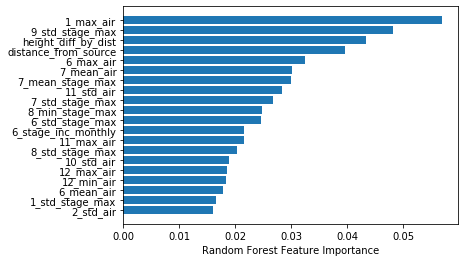

In [91]:
importances = model.feature_importances_
feature_names = X_train_used.columns
sorted_idx = importances.argsort()[-20:]


plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.xlabel("Random Forest Feature Importance")


In [93]:
pickle.dump(model, open(sumbit_dir + 'submit-rf' + now.strftime("%m-%d-%Y-%H-%M") + '.pkl', 'wb'))

In [ ]:
search_grid_xgb = {'max_depth': [2, 3, 4, 5, 6],
                  'max_features': [3, 4, 5, 6],
                  'n_estimators': [100, 150, 500],
                  'random_state': [29]
                  }



param_search_xgb = GridSearchCV(estimator=model, 
                               param_grid=search_grid_xgb, 
                               scoring=metrics.make_scorer(metrics.f1_score),
                               cv=3, 
                               n_jobs=-1, 
                               verbose=2, return_train_score=True,
                               iid=True)
param_search_xgb.fit(X_train_used, 
                     y_train, early_stopping_rounds=10, 
                     eval_set=[(X_test_used, y_test)] , verbose=True)        

print(param_search_xgb.best_params_)
mod_opt_xgb = XGBClassifier(**param_search_xgb.best_params_)
mod_opt_xgb = mod_opt_xgb.fit(X_train_used, y_train)

y_pred = mod_opt_xgb.predict(X_test_used)
y_train_pred = mod_opt_xgb.predict(X_train_used)

threshold_RF = 0.3
print('F1-train: {}'.format(f1_score(y_train, y_train_pred)))
print('F1-test: {}'.format(f1_score(y_test, y_pred)))